In [1]:
from importlib import reload
import flymovie as fm
from flymovie.simnuc import Sim
import cnn_models.siamese_cnn as cn
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pickle
from pathlib import Path
import scipy.ndimage as ndi
from importlib import reload
import tensorflow as tf
import scipy
import pandas as pd
import sklearn

%load_ext autoreload
%autoreload 2

In [13]:
def load_images(folder, mip=True):
    def normalize_params(params):
        std = np.std(params, axis=0)
        std[std == 0] = 1e6
        p = params.copy()
        p = (p - p.mean(axis=0)) / std
        return p
        
    ims = []
    params = np.ndarray((0,12))
    files = os.listdir(folder)
    for f in files:
        if f[3] != '_':
            continue
        filename = os.path.join(folder, f)
        with open(filename, 'rb') as file:
            im = pickle.load(file)
        if mip:
            im = im.max(axis=0)
        im = im.astype('float32')
        im = np.expand_dims(im, axis=-1)
        # Normalize 0-1.
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        ims.append(im)

        p= f.split('_')[1:-1]
        p = [float(x) for x in p]
        params = np.vstack([params, p])
    
    params = normalize_params(params)
    return ims, params

def batch_embedding(ims, embedding, mip=True):
    embed = np.ndarray((0,256))
    for i in range(len(ims)):
        im = ims[i]
        p = params[i]
        im = np.expand_dims(im, axis=0)
        e = embedding(im).numpy()
        embed = np.vstack([embed, e])
        
    return embed 



def show_nearest(ims, embed, mip=True, maxval=99):
    def nearest(data, n):
        ref = data[n]
        f = lambda x: scipy.spatial.distance.euclidean(x, ref)
        dists = np.apply_along_axis(f, 1, data)
        indxs = np.argsort(dists)
        return indxs
    
    def show(ax, im):
        im_ = im.copy()
        if len(im_.shape) == 4:
            im_ = im_.max(axis=0)
        max_ = np.percentile(im_, maxval)
        ax.imshow(im_, vmax=max_)
        
    fig, ax = plt.subplots(5,5, figsize=(10,10))
    for i in range(5):
        anchor_idx, r1, r2 = np.random.randint(0, len(ims) - 1, 3)
        nearest_idxs = nearest(embed, anchor_idx)
        if nearest_idxs[0] == anchor_idx:
            nearest_idxs = nearest_idxs[1:]
        
        show(ax[i,0], ims[anchor_idx])
        show(ax[i,1], ims[nearest_idxs[0]])
        show(ax[i,2], ims[nearest_idxs[1]])
        show(ax[i,3], ims[nearest_idxs[r1]])
        show(ax[i,4], ims[nearest_idxs[r2]])
        plt.tight_layout()

def plot_pairs(params, embed, n):
    names=['nuc_bg','nonnuc_bg','noise_sigma',
            'nblobs','blob_intensity_mean','blob_intensity_std',
            'blob_sigma_base','blob_sigma_k','blob_sigma_theta',
            'hlb_intensity','hlb_sigma','hlb_p']
    def dist(a1, a2):
        return np.sqrt(((a1 - a2) ** 2).sum(axis=1))
    r1 = np.random.randint(0, params.shape[0] - 1, n)  
    r2 = np.random.randint(0, params.shape[0] - 1, n)
    r1[r1 == r2] += 1
    p_dist = abs(params[r1,:] - params[r2,:])
    e_dist = dist(embed[r1,:], embed[r2,:])

    fig, axes_ = plt.subplots(3,4, figsize=(15,10))
    axes = np.ravel(axes_)
    for i in range(len(axes)):
        ax = axes[i]
        ax.scatter(np.log(e_dist), p_dist[:,i], alpha=0.2)
        ax.set_title(names[i])
    plt.tight_layout()

In [18]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/checkpoint_gpu_20220127_mip'
base_cnn = cn.make_base_cnn(image_shape=(100,100))
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [19]:
# Calculate the embeddings of some input images.
folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/test_sims_realnuc_1000_iAKPibSh/left'
mips, params = load_images(folder)
embed = batch_embedding(mips, embedding,True)

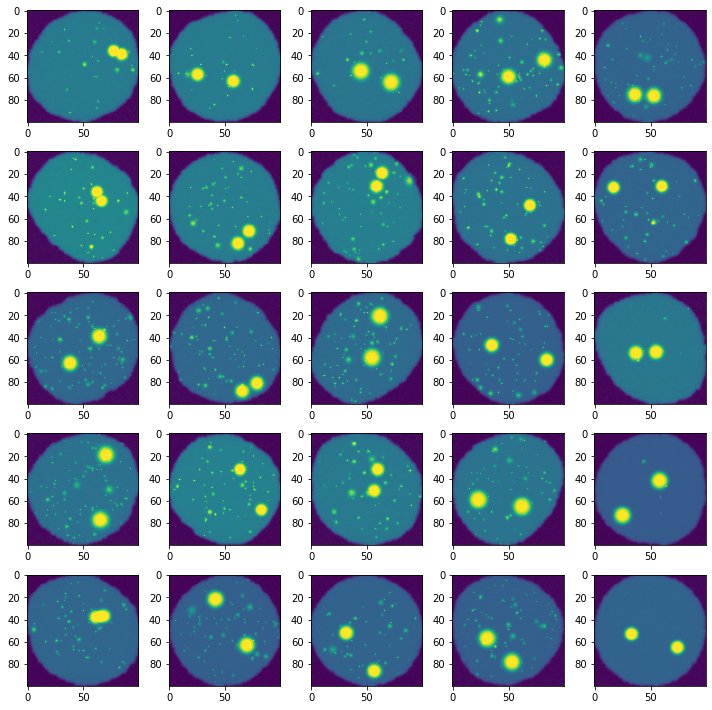

In [20]:
show_nearest(mips, embed)

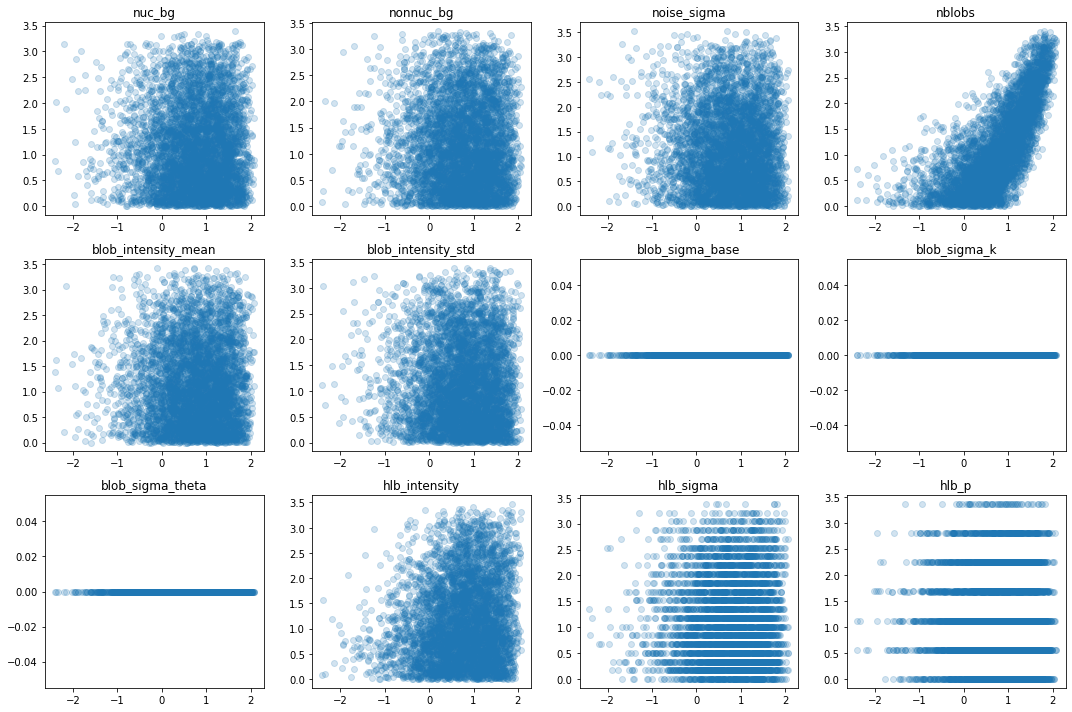

In [21]:
plot_pairs(params, embed,5_000)

In [24]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/checkpoint_gpu_20220127'
base_cnn = cn.make_base_cnn_3d(image_shape=(20,100,100))
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [25]:
# Calculate the embeddings of some input images.
folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/test_sims_realnuc_1000_iAKPibSh/left'
ims2, params2 = load_images(folder, mip=False)
embed2 = batch_embedding(ims2, embedding, mip=False)

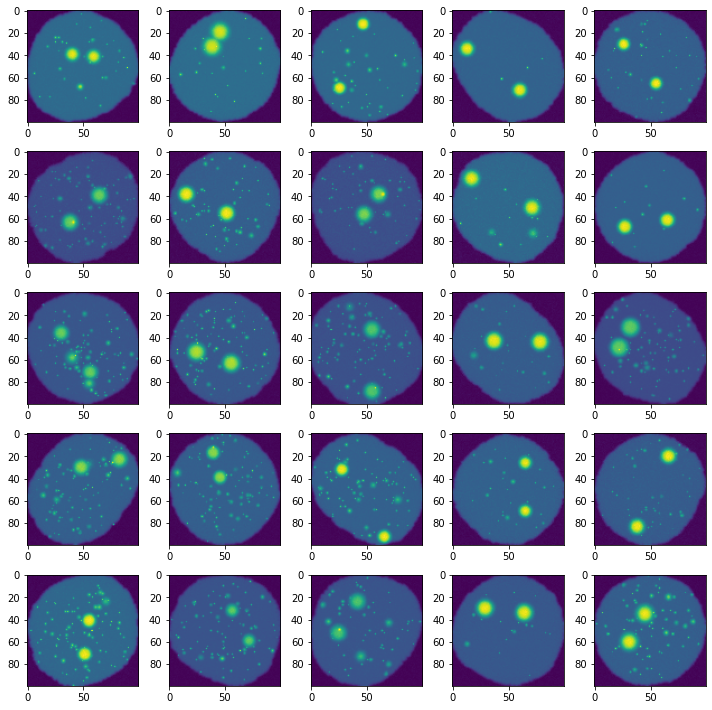

In [129]:
show_nearest(ims, embed3d)

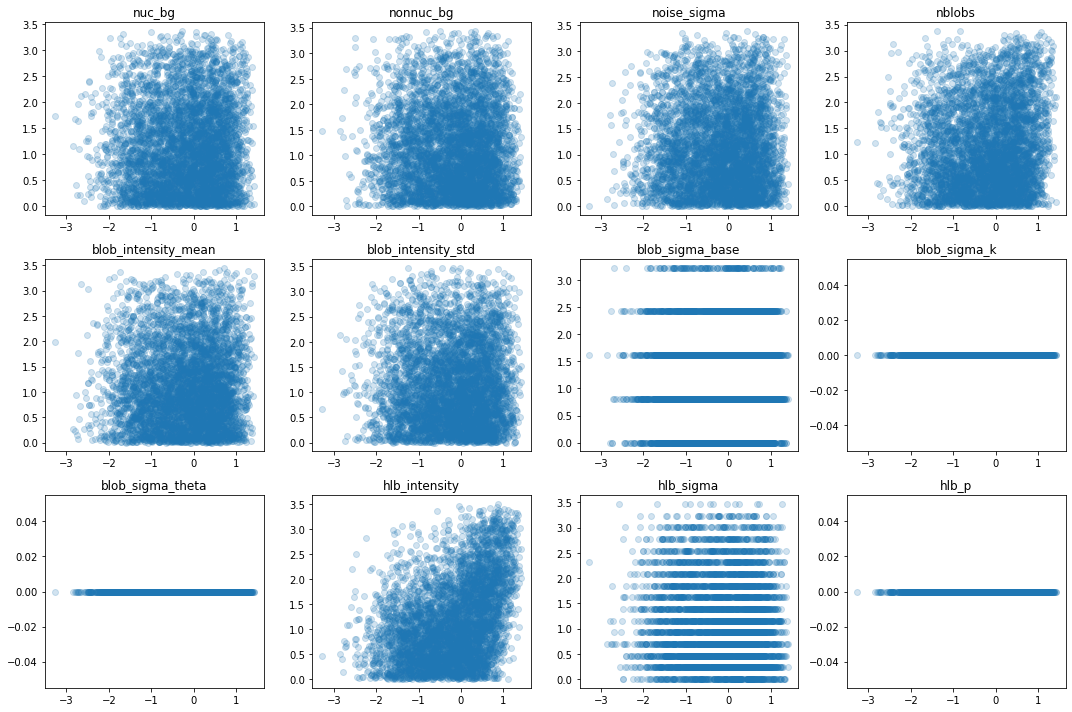

In [27]:
plot_pairs(params3, embed3, 5_000)

In [46]:
# MMost recent MIP
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/variables/checkpoint_gpu_20220201_mip'
base_cnn = cn.make_base_cnn(image_shape=(100,100))
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [6]:
# Calculate the embeddings of some input images.
folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/goodrpb1_sPukLpTN'
ims3, params3 = load_images(folder, mip=True)
embed3 = batch_embedding(ims, embedding, mip=True)

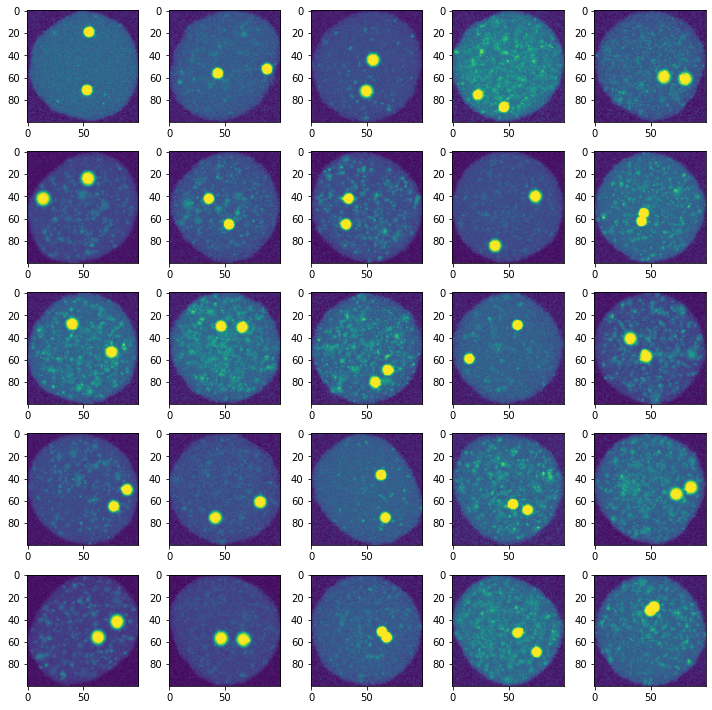

In [10]:
show_nearest(ims, embed)

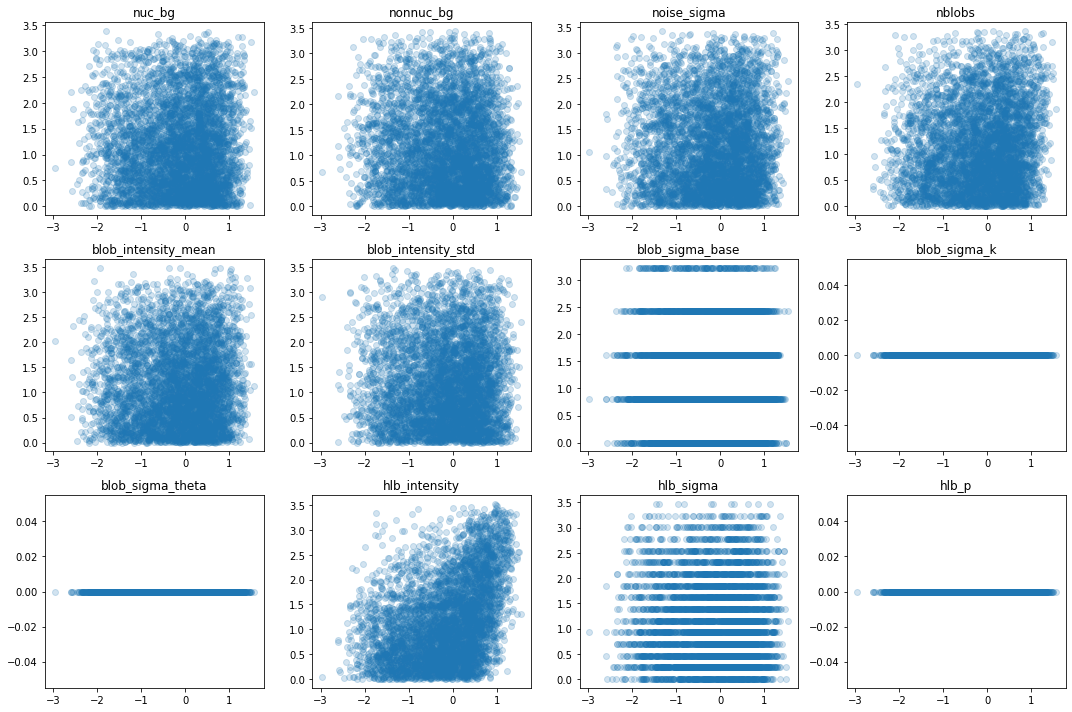

In [14]:
plot_pairs(params, embed, 5_000)

In [32]:
from pathlib import Path
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/goodrpb1_sPukLpTN')
train_dataset, val_dataset = cn.make_triplet_inputs(cache_dir, mip=True)

In [47]:
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 1)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________

In [54]:
correct = 0
wrong = 0
for batch in train_dataset:
    a,p,n = [x.numpy() for x in batch]
    print('batch')
    for i in range(a.shape[0]):
        a_embedding = embedding(np.expand_dims(a[i], axis=0))
        p_embedding = embedding(np.expand_dims(p[i], axis=0))
        n_embedding = embedding(np.expand_dims(n[i], axis=0))
        positive_similarity = scipy.spatial.distance.euclidean(a_embedding, p_embedding)
        negative_similarity = scipy.spatial.distance.euclidean(a_embedding, n_embedding)
        if positive_similarity < negative_similarity:
            correct += 1
        else:
            wrong += 1

print(correct, wrong)
        

656 144


In [55]:
656/(656+144)

0.82

In [33]:

    sample = next(iter(train_dataset))
    #visualize(*sample)

    anchor, positive, negative = sample
    anchor = anchor.numpy()
    positive = positive.numpy()
    negative = negative.numpy()

    anchor_embedding, positive_embedding, negative_embedding = (
        embedding(preprocess_image(anchor)),
        embedding(preprocess_image(positive)),
        embedding(preprocess_image(negative)),
    )

    cosine_similarity = tf.keras.metrics.CosineSimilarity()

    positive_similarity = scipy.spatial.distance.euclidean(anchor_embedding, positive_embedding)
    negative_similarity = scipy.spatial.distance.euclidean(anchor_embedding, negative_embedding)
    print('positive: ' + str(positive_similarity))
    print('negative: ' + str(negative_similarity))

2022-02-02 11:55:50.733268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


NameError: name 'preprocess_image' is not defined